In [1]:
import os ##冰激淋+擔擔麵+蜂蜜檸檬適用

os.environ["CUDA_VISIBLE_DEVICES"] = "1" #使用第0張顯卡 ##冰激淋+擔擔麵+蜂蜜檸檬適用 0or1

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
from PIL import Image
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K

In [4]:

"""
基本設定
"""
n=148335 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=36 #288個一組 (24小時一組)
currency = ["BTC","DASH","ETH","LTC","XMR"]
currencynum = len(currency)
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
daynum = [0,5803,11746,18352,24381,30580,36862,42796,49202,55343,61231,67401,73733,79985,85727,92344,98128,104693,111029,117077,123701,129808,136084,142402,148336]
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
question = ["trand","volatility"]
# 貨幣組合，1 : P, 0 : C
M=0

epochs = 30
batch_size = 4096

all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出

In [5]:
"""""""""
str, onehotcode, company code轉換
"""""""""


currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)

In [6]:
"""
Q&A
"""
vol='volatility'
def set_question(com1, com2,typeq):
    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)]))

qtype = ['big']
HVqtype = ['big']

"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])
    outcome[1]=(data2_sum[1])
    outcome[2]=(data2_sum[2])
    outcome[3]=(data2_sum[3])
    outcome[4]=(data2_sum[4])
    tmp_q = []
    tmp_a = []
    for j in range(len(all_cur_pair_P)):
        tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1],all_question[0][0]))
    q_pair[i] = tmp_q        
    for j in range(len(all_cur_pair_P)):
        if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
            tmp_a.append(1)
        else:
            tmp_a.append(0)
    a_pair[i] = tmp_a
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    data2_std=np.std(data2,axis=1) 
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
    tmp_q = []
    tmp_a = []   
    for j in range(len(all_cur_pair_P)):
        tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1],all_question[1][0]))
    q_HVpair[i] = tmp_q
    for j in range(len(all_cur_pair_P)):
        if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
            tmp_a.append(1)
        else:
            tmp_a.append(0)
                
    a_HVpair[i] = tmp_a    
    return (data, q_HVpair, a_HVpair)

In [7]:
"""
網路函數
"""
def ConvolutionNetworks(filter_num,kernel_size):
    def conv(model):
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = (MaxPooling1D(pool_size=6))(model)
        model = BatchNormalization()(model)
        return model
    return conv


def f_theta():
    def f(model):
        model = Dense(64)(model)
        model = Activation('relu')(model)
        model = Dense(64)(model)
        model = Activation('relu')(model)
        model = Dense(64)(model)
        model = Activation('relu')(model)
#        model = Dense(64)(model)
#        model = Activation('relu')(model)
        model = Dense(64)(model)
        model = Dropout(0.5)(model)
        model = Activation('relu')(model)
        return model
    return f

In [8]:
"""
此處開始寫rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==60):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==60):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])


    """
    算benchmark
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("benchacc:")
    print(benchacc)
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    print("loss:")
    print(history.history['loss'][-1])
    print("val_loss:")
    print(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['acc'], label='train')
    lastepoch_train_acc.append(history.history['acc'][-1])
    plt.plot(history.history['val_acc'], label='test')
    lastepoch_test_acc.append(history.history['val_acc'][-1])  
    plt.plot(np.arange(epochs),np.repeat(benchacc,epochs), label='benchmark')
    print("acc:")
    print(history.history['acc'][-1])
    print("val_acc:")
    print(history.history['val_acc'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("acc") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()

(148335, 1)
(148335, 1)
(148335, 1)
(148335, 1)
(148335, 1)
finish dataread
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=668 MiB, count=2, average=334 MiB
[Training model......]
Train on 370780 samples, validate on 114240 samples
Epoch 1/30
370780/370780 [==============================] - 4s 10us/step - loss: 0.6946 - acc: 0.5163 - val_loss: 0.6832 - val_acc: 0.6074
Epoch 2/30
370780/370780 [==============================] - 1s 4us/step - loss: 0.6878 - acc: 0.5500 - val_loss: 0.6759 - val_acc: 0.6100
Epoch 3/30
370780/370780 [==============================] - 1s 4us/step - loss: 0.6832 - acc: 0.5642 - val_loss: 0.6690 - val_acc: 0.6100
Epoch 4/30
370780/370780 [==============================] - 1s 4us/step - loss: 0.6779 - acc: 0.5737 - val_loss: 0.6600 - val_acc: 0.6120
Epoch 5/30
370780/370780 [==============================] - 2s 4us/step - loss: 0.6694 - acc: 0.5882 - val_loss: 0.6465 - val_acc: 0.6277
Epoch 6/30
370780/370

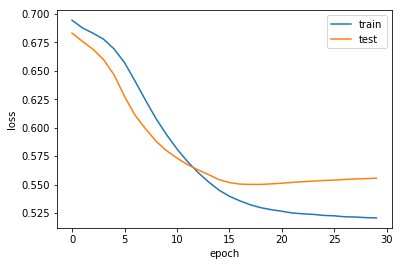

acc:
0.6658935216022441
val_acc:
0.6187675076038563


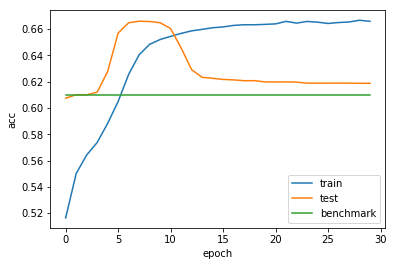

(148335, 1)
(148335, 1)
(148335, 1)
(148335, 1)
(148335, 1)
finish dataread
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=677 MiB, count=57, average=11.9 MiB
[Training model......]
Train on 361420 samples, validate on 129860 samples
Epoch 1/30
361420/361420 [==============================] - 3s 7us/step - loss: 0.6900 - acc: 0.5357 - val_loss: 0.6779 - val_acc: 0.6139
Epoch 2/30
361420/361420 [==============================] - 1s 4us/step - loss: 0.6829 - acc: 0.5624 - val_loss: 0.6661 - val_acc: 0.6152
Epoch 3/30
361420/361420 [==============================] - 2s 4us/step - loss: 0.6763 - acc: 0.5720 - val_loss: 0.6564 - val_acc: 0.6173
Epoch 4/30
361420/361420 [==============================] - 1s 4us/step - loss: 0.6693 - acc: 0.5820 - val_loss: 0.6480 - val_acc: 0.6375
Epoch 5/30
361420/361420 [==============================] - 1s 4us/step - loss: 0.6600 - acc: 0.5979 - val_loss: 0.6378 - val_acc: 0.6537
Epoch 6/30
361420/36

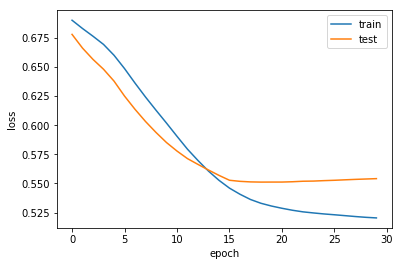

acc:
0.6673731392733808
val_acc:
0.6179269986161462


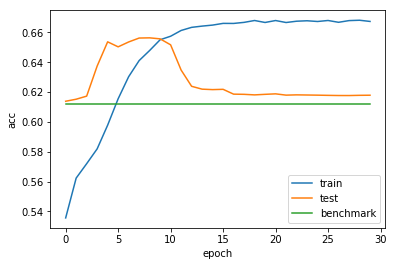

(148335, 1)
(148335, 1)
(148335, 1)
(148335, 1)
(148335, 1)
finish dataread
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=693 MiB, count=59, average=11.7 MiB
[Training model......]
Train on 377880 samples, validate on 125280 samples
Epoch 1/30
377880/377880 [==============================] - 3s 7us/step - loss: 0.6920 - acc: 0.5261 - val_loss: 0.6752 - val_acc: 0.6118
Epoch 2/30
377880/377880 [==============================] - 2s 4us/step - loss: 0.6857 - acc: 0.5553 - val_loss: 0.6673 - val_acc: 0.6127
Epoch 3/30
377880/377880 [==============================] - 2s 4us/step - loss: 0.6806 - acc: 0.5632 - val_loss: 0.6602 - val_acc: 0.6126
Epoch 4/30
377880/377880 [==============================] - 1s 4us/step - loss: 0.6742 - acc: 0.5678 - val_loss: 0.6508 - val_acc: 0.6128
Epoch 5/30
377880/377880 [==============================] - 1s 4us/step - loss: 0.6654 - acc: 0.5744 - val_loss: 0.6389 - val_acc: 0.6149
Epoch 6/30
377880/37

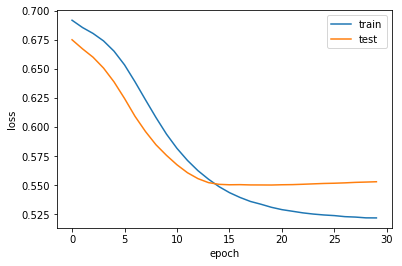

acc:
0.6655313855985668
val_acc:
0.6221503836289524


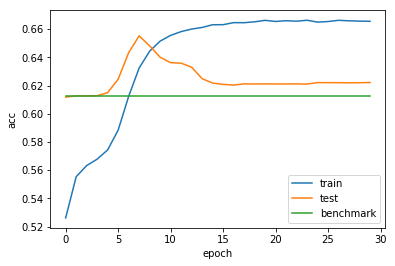

(148335, 1)
(148335, 1)
(148335, 1)
(148335, 1)
(148335, 1)
finish dataread
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=677 MiB, count=61, average=11.1 MiB
[Training model......]
Train on 372260 samples, validate on 119520 samples
Epoch 1/30
372260/372260 [==============================] - 3s 8us/step - loss: 0.7009 - acc: 0.4946 - val_loss: 0.6894 - val_acc: 0.5411
Epoch 2/30
372260/372260 [==============================] - 2s 4us/step - loss: 0.6871 - acc: 0.5494 - val_loss: 0.6725 - val_acc: 0.6209
Epoch 3/30
372260/372260 [==============================] - 2s 4us/step - loss: 0.6804 - acc: 0.5729 - val_loss: 0.6624 - val_acc: 0.6272
Epoch 4/30
372260/372260 [==============================] - 1s 4us/step - loss: 0.6736 - acc: 0.5887 - val_loss: 0.6521 - val_acc: 0.6355
Epoch 5/30
372260/372260 [==============================] - 1s 4us/step - loss: 0.6646 - acc: 0.6060 - val_loss: 0.6401 - val_acc: 0.6486
Epoch 6/30
372260/37

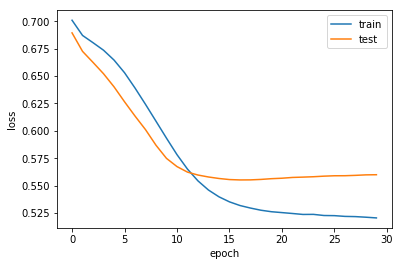

acc:
0.6655617043492053
val_acc:
0.6208584337189813


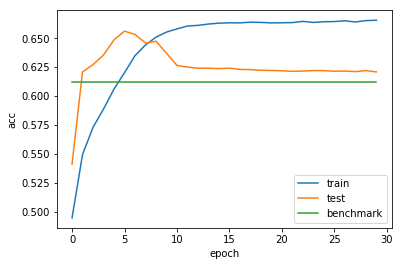

(148335, 1)
(148335, 1)
(148335, 1)
(148335, 1)
(148335, 1)
finish dataread
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=700 MiB, count=62, average=11.3 MiB
[Training model......]
Train on 377540 samples, validate on 131040 samples
Epoch 1/30
377540/377540 [==============================] - 3s 8us/step - loss: 0.6914 - acc: 0.5389 - val_loss: 0.6769 - val_acc: 0.6120
Epoch 2/30
377540/377540 [==============================] - 1s 3us/step - loss: 0.6861 - acc: 0.5584 - val_loss: 0.6707 - val_acc: 0.6119
Epoch 3/30
377540/377540 [==============================] - 2s 5us/step - loss: 0.6803 - acc: 0.5659 - val_loss: 0.6633 - val_acc: 0.6119
Epoch 4/30
377540/377540 [==============================] - 2s 4us/step - loss: 0.6732 - acc: 0.5718 - val_loss: 0.6531 - val_acc: 0.6119
Epoch 5/30
377540/377540 [==============================] - 1s 4us/step - loss: 0.6639 - acc: 0.5822 - val_loss: 0.6406 - val_acc: 0.6122
Epoch 6/30
377540/37

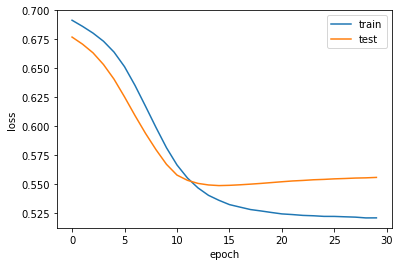

acc:
0.6632197912292422
val_acc:
0.6197573257744385


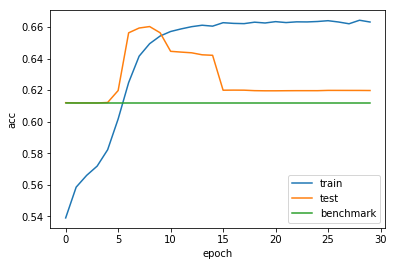

In [9]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
head = 12
tail = 17
for z in range(head,tail,1):
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/btc_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    btc5months = np.zeros(n)
    for i in range(n):
        btc5months[i] = df[0][i]
    df = pd.read_csv('data/DASH_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    dash5months = np.zeros(n)
    for i in range(n):
        dash5months[i] = df[0][i]
    df = pd.read_csv('data/eth_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    eth5months = np.zeros(n)
    for i in range(n):
        eth5months[i] = df[0][i]
    df = pd.read_csv('data/LTC_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    ltc5months = np.zeros(n)
    for i in range(n):
        ltc5months[i] = df[0][i]
    df = pd.read_csv('data/XMR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    xmr5months = np.zeros(n)
    for i in range(n):
        xmr5months[i] = df[0][i]    
    print('finish dataread')

    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=btc5months[p:p+l]
        Train_data[p,1,:]=dash5months[p:p+l]
        Train_data[p,2,:]=eth5months[p:p+l]
        Train_data[p,3,:]=ltc5months[p:p+l]
        Train_data[p,4,:]=xmr5months[p:p+l]
    MLP_unit=64
    baseline_scene = Input((l,currencynum))
    baseline_question = Input((12,))
    baseline_conv = ConvolutionNetworks(20,5)(baseline_scene)
    baseline_conv = Flatten()(baseline_conv)
    baseline_conv = Concatenate()([baseline_conv, baseline_question])
    baseline_output = f_theta()(baseline_conv) 
    baseline_output = Dense(1, activation='sigmoid')(baseline_output)
#    baseline_output = Dense(1, activation='linear')(baseline_output) 
    optimizer = Adam(lr = 3e-5)
    model = Model(inputs=[baseline_scene, baseline_question], outputs=baseline_output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#    BaseLineModel.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#    model.summary()
    print('compile model success')  
    print(z)
    fit_show(Train_data,daynum[z] ,daynum[z+3] ,daynum[z+4]) 

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 36, 5)        0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 32, 20)       520         input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 28, 20)       2020        conv1d_13[0][0]                  
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 24, 20)       2020        conv1d_14[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [12]:
K.clear_session()